In [1]:
pip install pydotplus

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: gpg 1.14.0-unknown has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of gpg or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pds
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [3]:
df = pds.read_csv('titanic/train.csv', sep=",") # load a pandas dataframe from csv in current directory
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
df.shape

(891, 12)

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Créeons l'attribut "classe". Ici, on s'interesse à la survie des passagers.

In [6]:
X = df.copy()
X.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


On doit préprocesser nos données. On peut garder des objets avec des colonnes vides, car les arbres de classification peuvent traiter ce type de données. Il peut aussi traiter les attributs nominatifs.
On enlève l'attribut "Name" et "Embarqued", "PassengerId" et "Ticket" qui ne nous semblent pas utiles.

In [7]:
del X["PassengerId"]
del X["Name"]
del X["Embarked"]
del X["Ticket"]
del X["Cabin"]
del X["Fare"]

Apparemment, l'algorithme n'est pas capable de traiter des données en string. On les change.

In [8]:
def transform_sex_to_int(X):
    gender=[]
    for element in X['Sex']:
        if element == 'male':
            gender.append(0)
        elif element == "female":
            gender.append(1)
        else:
            gender.append(float('nan'))
            
    X["Sex"]=gender
    return

In [9]:
transform_sex_to_int(X)

In [10]:
X.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,0,22.0,1,0
1,1,1,1,38.0,1,0
2,1,3,1,26.0,0,0
3,1,1,1,35.0,1,0
4,0,3,0,35.0,0,0


In [11]:
X['Age'].isnull().sum()

177

In [12]:
X=X.dropna()
X['Age'].isnull().sum()

0

Créons notre arbre de décision

In [13]:
y=X["Survived"]
del X["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

In [14]:
from collections import Counter
Counter(y)

Counter({0: 424, 1: 290})

In [15]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

Utilisons notre arbre pour prédire le taux de survie du dataframe test

In [16]:
y_predict = dt.predict(X_test)

In [17]:
pds.crosstab(y_test,y_predict)

col_0,0,1
Survived,,
0,49,11
1,12,36


In [18]:
accuracy_score(y_test,y_predict)

0.7870370370370371

In [19]:
precision_score(y_test,y_predict,average="weighted"), precision_score(y_test,y_predict,average="macro")

(0.7866914699841103, 0.7846180676665504)

In [20]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

In [21]:
feature_cols=X.columns

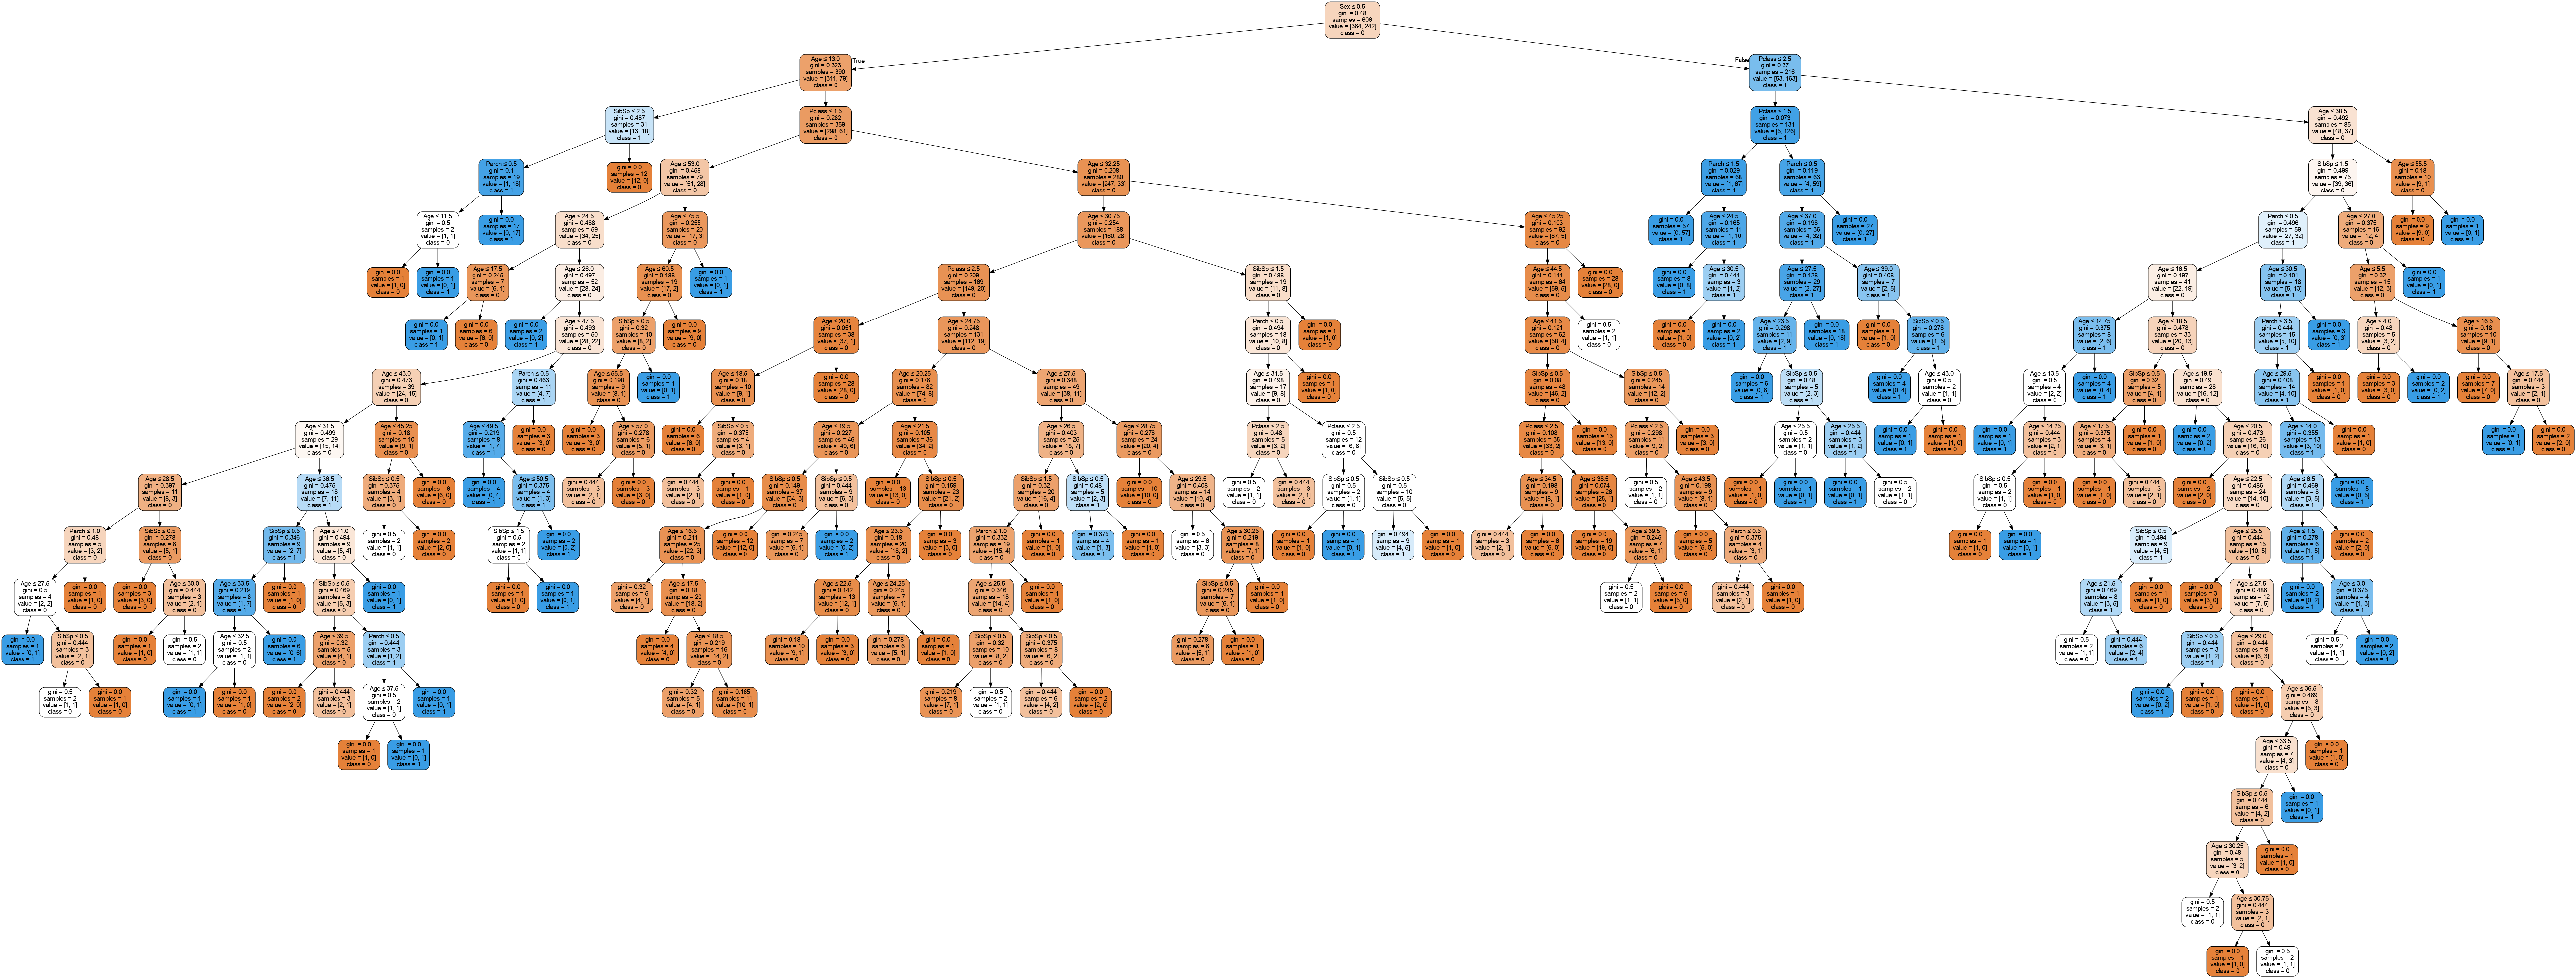

In [22]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Survival.png')
Image(graph.create_png())

Let's avoid overfitting from the decision tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

param_grid = {
    "max_depth": [3,5,6,7,8,9,10,15,20,None],
    "min_samples_split": [2,3,4,5,7,8,9,10],
    "min_samples_leaf": [1,2,3,4,5]
}

clf = DecisionTreeClassifier(random_state=42)
grid_cv = GridSearchCV(clf, param_grid, scoring="roc_auc", n_jobs=-1, cv=3).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ", roc_auc_score(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 9}
CV score for GS 0.8477643092764594
Train AUC ROC Score for GS:  0.8278880210698393
Test AUC ROC Score for GS:  0.7479166666666668


In [24]:
dt_2 = DecisionTreeClassifier(random_state=42,max_depth= 6, min_samples_leaf= 3, min_samples_split= 9)
dt_2.fit(X_train,y_train)
y_predict_2 = dt_2.predict(X_test)
pds.crosstab(y_test,y_predict_2)

col_0,0,1
Survived,,
0,51,9
1,17,31


In [25]:
accuracy_score(y_test,y_predict_2)

0.7592592592592593

In [26]:
accuracy_score(y_test,y_predict_2)-accuracy_score(y_test,y_predict)

-0.02777777777777779

In [27]:
precision_score(y_test,y_predict_2,average="weighted")-precision_score(y_test,y_predict,average="weighted")

-0.025580358872999143

In [28]:
precision_score(y_test,y_predict_2,average="macro")-precision_score(y_test,y_predict,average="macro")

-0.022118067666550445

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [29]:
from sklearn.metrics import recall_score
recall_score(y_test,y_predict,average="weighted"), recall_score(y_test,y_predict,average="macro")

(0.7870370370370371, 0.7833333333333333)

The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is: F1 = 2 * (precision * recall) / (precision + recall)

In [30]:
from sklearn.metrics import f1_score
f1_score(y_test,y_predict,average="weighted"), f1_score(y_test,y_predict,average="macro")

(0.7867961915808805, 0.7839060461070031)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81        60
           1       0.77      0.75      0.76        48

    accuracy                           0.79       108
   macro avg       0.78      0.78      0.78       108
weighted avg       0.79      0.79      0.79       108



In [32]:
dt_3 = DecisionTreeClassifier(random_state=42, class_weight={0:0.7,1:0.3})
dt_3.fit(X_train,y_train)
y_predict_3 = dt_3.predict(X_test)
pds.crosstab(y_test,y_predict_3)

col_0,0,1
Survived,,
0,52,8
1,12,36


In [33]:
accuracy_score(y_test,y_predict_3)

0.8148148148148148

In [34]:
print(classification_report(y_test, y_predict_3))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84        60
           1       0.82      0.75      0.78        48

    accuracy                           0.81       108
   macro avg       0.82      0.81      0.81       108
weighted avg       0.82      0.81      0.81       108



# Cross-validation

In [35]:
from sklearn.model_selection import StratifiedKFold #cross-validation splitter
from sklearn.model_selection import cross_validate #cross-validation evaluation of metrics

In [36]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

In [37]:
scoring = ['accuracy',
           'precision_macro',
           'precision_weighted',
           'recall_macro',
           'recall_weighted',
           'f1_macro',
           'f1_weighted']

In [38]:
scores = cross_validate(dt, X, y, scoring=scoring,
                        cv=cv, return_train_score=True)

In [39]:
pds.DataFrame(scores).mean()

fit_time                    0.002168
score_time                  0.008509
test_accuracy               0.778686
train_accuracy              0.939425
test_precision_macro        0.773262
train_precision_macro       0.948705
test_precision_weighted     0.777953
train_precision_weighted    0.942550
test_recall_macro           0.764603
train_recall_macro          0.928019
test_recall_weighted        0.778686
train_recall_weighted       0.939425
test_f1_macro               0.767541
train_f1_macro              0.935885
test_f1_weighted            0.777035
train_f1_weighted           0.938712
dtype: float64

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

from sklearn.model_selection import (
    GroupKFold,
    GroupShuffleSplit,
    KFold,
    ShuffleSplit,
    StratifiedGroupKFold,
    StratifiedKFold,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
)

In [41]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            vmin=-0.2,
            vmax=1.2,
        )


    # Formatting
    yticklabels = list(range(n_splits)) 
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits+0.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

<Axes: title={'center': 'StratifiedKFold'}, xlabel='Sample index', ylabel='CV iteration'>

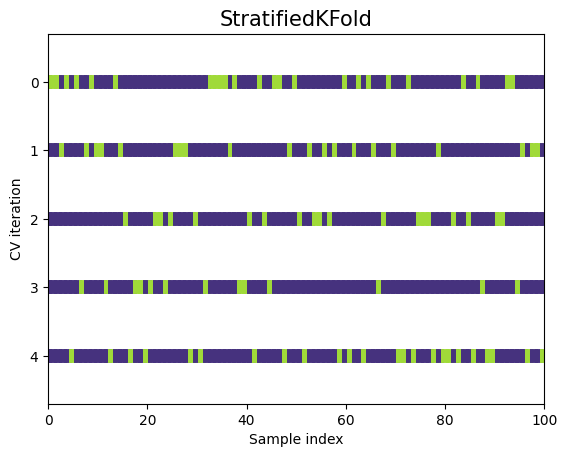

In [42]:
fig, ax = plt.subplots()
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
plot_cv_indices(cv, X, y, ax, n_splits=5)

## Overfitting du cours

<Axes: title={'center': 'StratifiedKFold'}, xlabel='Sample index', ylabel='CV iteration'>

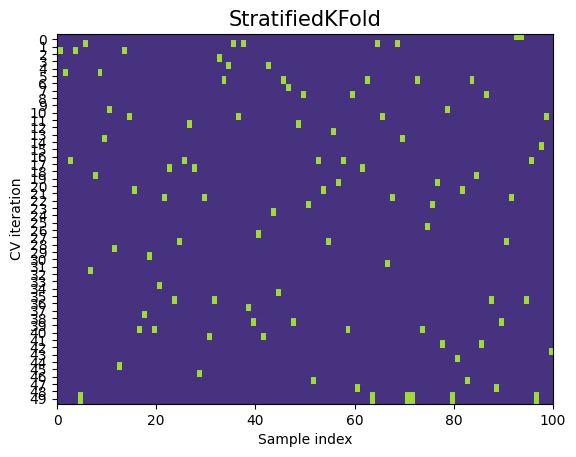

In [43]:
import matplotlib.pyplot as plt
# Test several maximum numbers of leaves
cv = StratifiedKFold(n_splits=50, random_state=0, shuffle=True)
fig, ax = plt.subplots()
plot_cv_indices(cv, X, y, ax, n_splits=50)

In [45]:
results = {}
for weight in range(1,9):
    dt = DecisionTreeClassifier(random_state=42,criterion="entropy",  class_weight={0:0.1*weight,1:1-0.1*weight})
    local_results = cross_validate(dt, X, y, scoring=["accuracy"],cv=cv, return_train_score=True)
    avg_local_results = pds.DataFrame(local_results).mean()
    results[weight] = avg_local_results
results_df = pds.DataFrame(results)

In [46]:
local_results # to see the format

{'fit_time': array([0.00204849, 0.00203323, 0.00205731, 0.00204587, 0.00203562,
        0.00204611, 0.00213504, 0.00203323, 0.00208879, 0.00202966,
        0.00204468, 0.00203633, 0.00204134, 0.00203466, 0.00209665,
        0.00205517, 0.0020504 , 0.00205255, 0.00205445, 0.00205159,
        0.00203824, 0.00203371, 0.00204349, 0.00207949, 0.00204706,
        0.00203943, 0.00203681, 0.00207639, 0.00206399, 0.00204825,
        0.00207806, 0.00202227, 0.00205112, 0.00207257, 0.00208569,
        0.00205302, 0.00204754, 0.00205898, 0.00202942, 0.00205684,
        0.00203061, 0.00204945, 0.00203681, 0.00203776, 0.00203323,
        0.00201917, 0.00211716, 0.00206733, 0.00204992, 0.00204492]),
 'score_time': array([0.00104308, 0.00102234, 0.00101209, 0.00100684, 0.00100923,
        0.0010066 , 0.00100398, 0.00100279, 0.00100613, 0.00100756,
        0.00103903, 0.0010283 , 0.00101042, 0.00101018, 0.00101161,
        0.00100923, 0.0010128 , 0.00100851, 0.0010035 , 0.00101042,
        0.00100708, 

Text(0.5, 0, 'Transfer of weight (more weight to the deads on the right)')

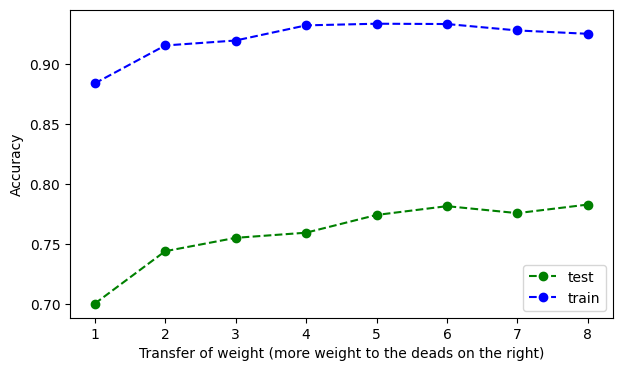

In [48]:
plt.figure(figsize=(7, 4))
plt.plot(results_df.T.index,
         results_df.T["test_accuracy"], "go--", label="test")
plt.plot(results_df.T.index,
         results_df.T["train_accuracy"],"bo--", label="train")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Transfer of weight (more weight to the deads on the right)")